<a href="https://colab.research.google.com/github/john-jiang-ca/MachineLearning/blob/master/ch2_e2e_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
housing = pd.read_csv("https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv")

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

# Hist on a pandas DataFrame

In [8]:
housing.head()

longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe6d6e50588>,
      dtype=object)

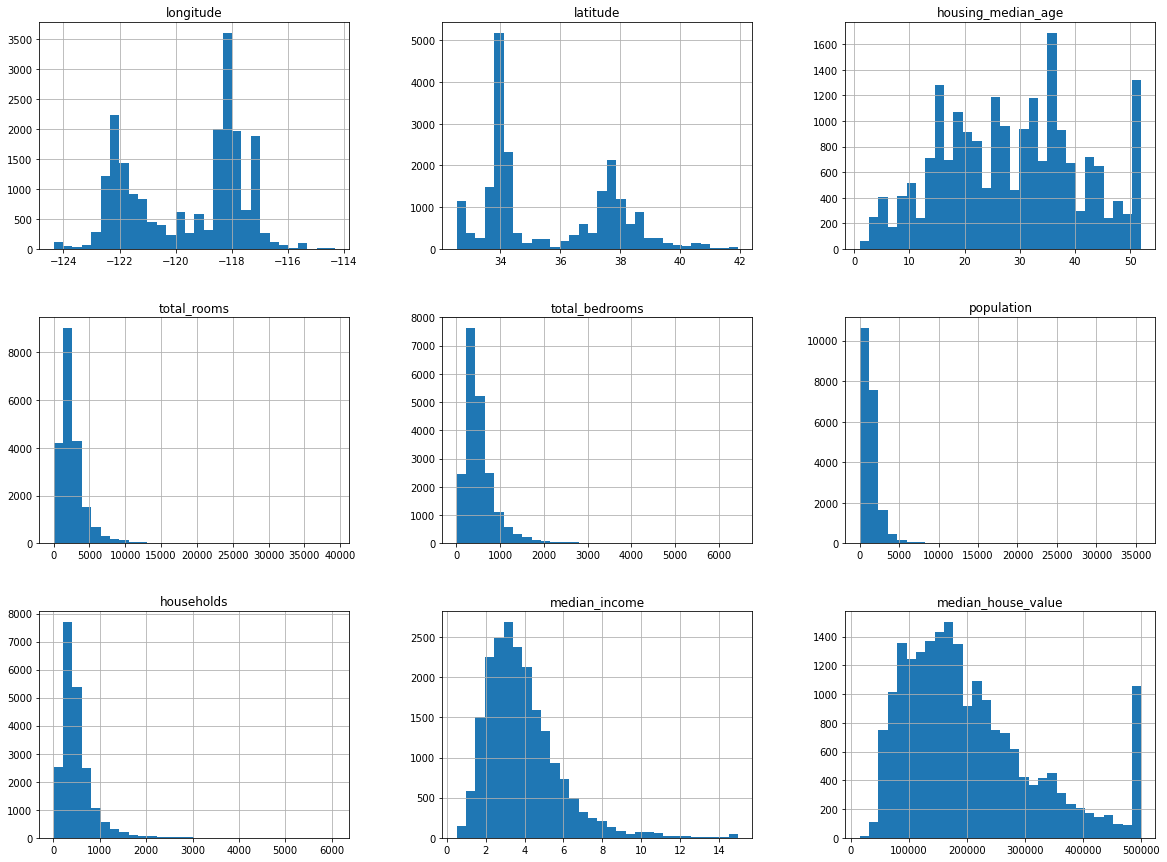

In [9]:
import matplotlib.pyplot as plt
housing.hist(bins=30, figsize=(20,15))

# ML Plans

## Create combined Attribute *Transformer*

In [32]:
class CombinedAttrTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols
  
  def fit(self, X, y=None):
    return self
  
  def transform(self, X, y=None):
    if not isinstance(X, pd.DataFrame):
      print("create dataframe")
      df = pd.DataFrame(X, columns=self.cols)
    else:
      df = X
    print("transform")
    df['rooms_per_hh'] = df['total_rooms'] / df['households']
    df['population_per_hh'] = df['population'] / df['households']
    df['bedrooms_per_hh'] = df['total_bedrooms'] / df['households']
    return df

## Split the test and train sets

In [11]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=0)

In [52]:
features = [x for x in housing.columns]
target = ['median_house_value']
features.remove('median_house_value')
X_train = train_set[features]
y_train = train_set[target]
X_test = test_set[features]
y_test = test_set[target]

In [53]:
X_test.head()


longitude  latitude  ...  median_income  ocean_proximity
14740    -117.05     32.58  ...         4.1518       NEAR OCEAN
10101    -117.97     33.92  ...         5.7796        <1H OCEAN
20566    -121.84     38.65  ...         4.3487           INLAND
2670     -115.60     33.20  ...         2.4511           INLAND
15709    -122.43     37.79  ...         5.0049         NEAR BAY

[5 rows x 9 columns]

In [14]:
y_train.head()

median_house_value
12069            500001.0
15925            270000.0
11162            196100.0
4904             118800.0
4683             225000.0

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder

In [36]:
category_cols = ['ocean_proximity']
bin_cols = ['longitude', 'latitude', 'housing_median_age']
num_cols = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

In [37]:
num_pipe = Pipeline([
                     ("imputer", SimpleImputer(strategy="median")),
                     ("attr_adder", CombinedAttrTransformer(num_cols)),
                     ("scaler", StandardScaler())
])

In [29]:
features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [38]:

full_pipeline = ColumnTransformer(
    [
     ("num", num_pipe, num_cols),
     ("cat", OneHotEncoder(), category_cols),
     ("bin", KBinsDiscretizer(n_bins=10), bin_cols)
    ]
)

In [40]:
X_train_clean = full_pipeline.fit_transform(X_train)

create dataframe
transform


In [44]:
# Try a Linear Regression as a baseline

In [45]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X_train_clean, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import mean_squared_error

In [48]:
scores = cross_val_score(lin_reg, X_train_clean, y_train, cv=10, n_jobs=-1, scoring="neg_mean_squared_error")
rmse = np.sqrt(-scores)

In [51]:
print(rmse)
print(rmse.mean())
print(rmse.std())

[69092.47207566 63432.15222175 66211.20176782 64612.42043216
 70019.81869822 65114.4138883  64827.10657958 64091.7174758
 69403.970917   61951.98947344]
65875.72635297358
2605.889543397918


In [57]:
X_test_clean=full_pipeline.transform(X_test)
y_test_predict = lin_reg.predict(X_test_clean)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print(rmse_test)

create dataframe
transform
65360.30361053899


#Use Plt to explore data

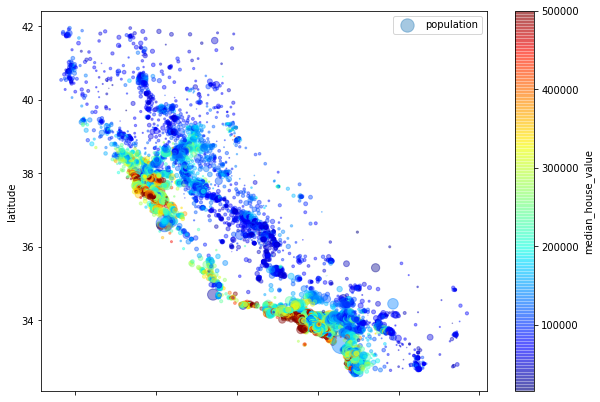

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing['population']/100, label="population", figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

# Explor corr for dataset

In [30]:
from pandas.plotting import scatter_matrix

In [43]:
col = housing.columns
index=range(len(col))
col = dict(zip(index, col))

In [44]:
col

{0: 'longitude',
 1: 'latitude',
 2: 'housing_median_age',
 3: 'total_rooms',
 4: 'total_bedrooms',
 5: 'population',
 6: 'households',
 7: 'median_income',
 8: 'median_house_value',
 9: 'ocean_proximity',
 10: 'income_bin_5'}

In [45]:
attr=[col[8], col[7], col[3], col[2]]

In [49]:
corr_matrix = housing.corr()

In [50]:
corr_matrix['median_house_value'].sort_values()

latitude             -0.144160
longitude            -0.045967
population           -0.024650
total_bedrooms        0.049686
households            0.065843
housing_median_age    0.105623
total_rooms           0.134153
income_bin_5          0.620465
median_income         0.688075
median_house_value    1.000000
Name: median_house_value, dtype: float64

# Exercises


In [51]:
housing.head()

longitude  latitude  ...  ocean_proximity  income_bin_5
0    -122.23     37.88  ...         NEAR BAY           4.0
1    -122.22     37.86  ...         NEAR BAY           4.0
2    -122.24     37.85  ...         NEAR BAY           4.0
3    -122.25     37.85  ...         NEAR BAY           4.0
4    -122.25     37.85  ...         NEAR BAY           2.0

[5 rows x 11 columns]

In [56]:
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [58]:
kbins_for_long_bin_10 = KBinsDiscretizer(n_bins=10)
kbins_for_lati_bin_10 = KBinsDiscretizer(n_bins=10)
kbins_for_house_age_5 = KBinsDiscretizer(n_bins=5)

In [65]:
cols = [x for x in train_set.columns.values]

In [73]:
target_col_name=  ['median_house_value']
if 'median_house_value' in cols:
  cols.remove('median_house_value')

In [84]:
train_set = train_set[train_set['total_bedrooms'].notnull()]
y_train = train_set[['median_house_value']]
X_train = train_set[cols]

In [87]:
from sklearn.preprocessing import StandardScaler
num_pipe = Pipeline([
                     ('scaler', StandardScaler())
]);


In [88]:
from sklearn.preprocessing import OneHotEncoder

In [89]:
full_pipe = ColumnTransformer([
                               ("num", StandardScaler(), ['total_rooms', 'total_bedrooms', 'population', 'households']),
                               ("bucketize_10", KBinsDiscretizer(encode="ordinal", n_bins=10), ['longitude', 'latitude']),
                               ("bucketize_5", KBinsDiscretizer(encode='ordinal', n_bins=5), ['housing_median_age', 'median_income']),
                               ("catygory", OneHotEncoder(), ['ocean_proximity'])
])

In [90]:
all_cols = ['total_rooms', 'total_bedrooms', 'population', 'households'] + ['longitude', 'latitude'] + ['housing_median_age', 'median_income'] + ['ocean_proximity']

In [92]:
X_train = X_train[all_cols]

In [93]:
from sklearn.linear_model import LinearRegression

In [94]:
X_prepared = full_pipe.fit_transform(X_train)

In [103]:
model = LinearRegression()

In [105]:
from sklearn.model_selection import cross_val_score

In [107]:
scores = cross_val_score(model, X_prepared, y_train, cv=10, scoring='neg_mean_squared_error')

In [108]:
import numpy as np

In [109]:
rmse = np.sqrt(-scores)

In [110]:
rmse

array([76705.78790736, 74230.7508137 , 77347.66431155, 75721.77519379,
       81420.0273445 , 77807.68110581, 74340.09972988, 75586.31457121,
       80978.99858973, 75089.97303396])